In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2



st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 10000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [3]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Morph1: Move inner target down to outer target level

In [5]:
%matplotlib inline
plt.close("all")

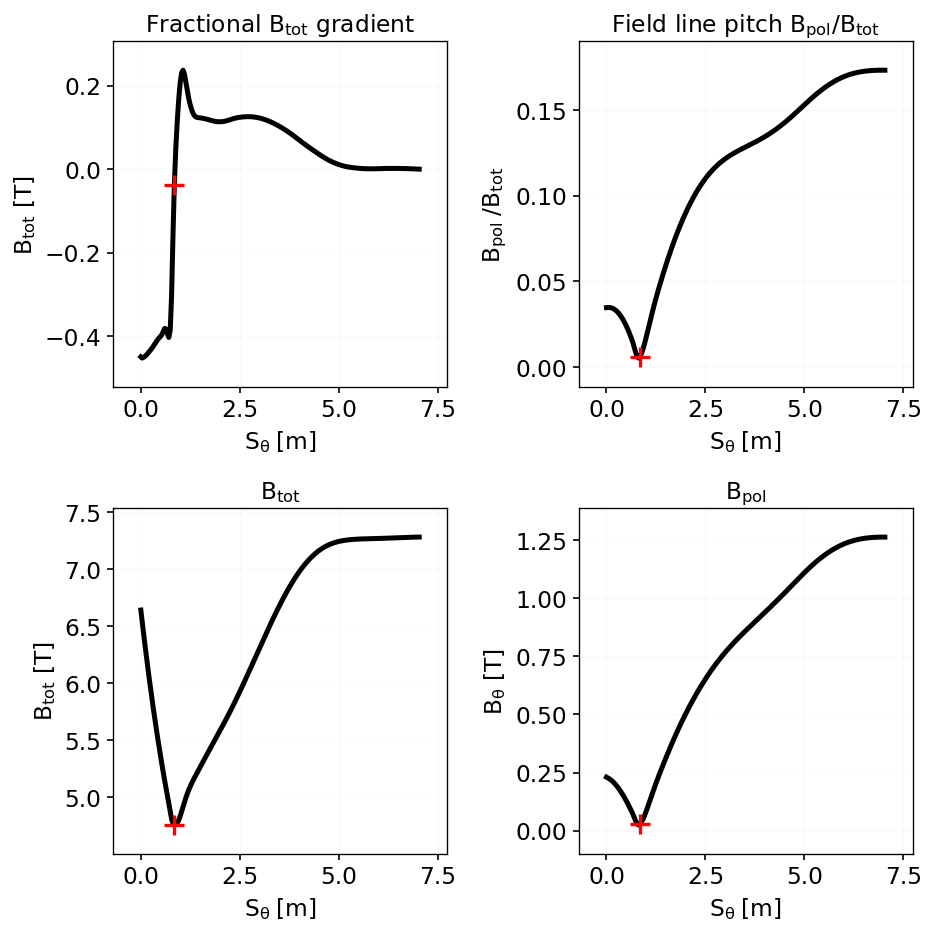

In [6]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

base.plot_topology()

In [6]:
%matplotlib inline

(-9.0, -5.8)

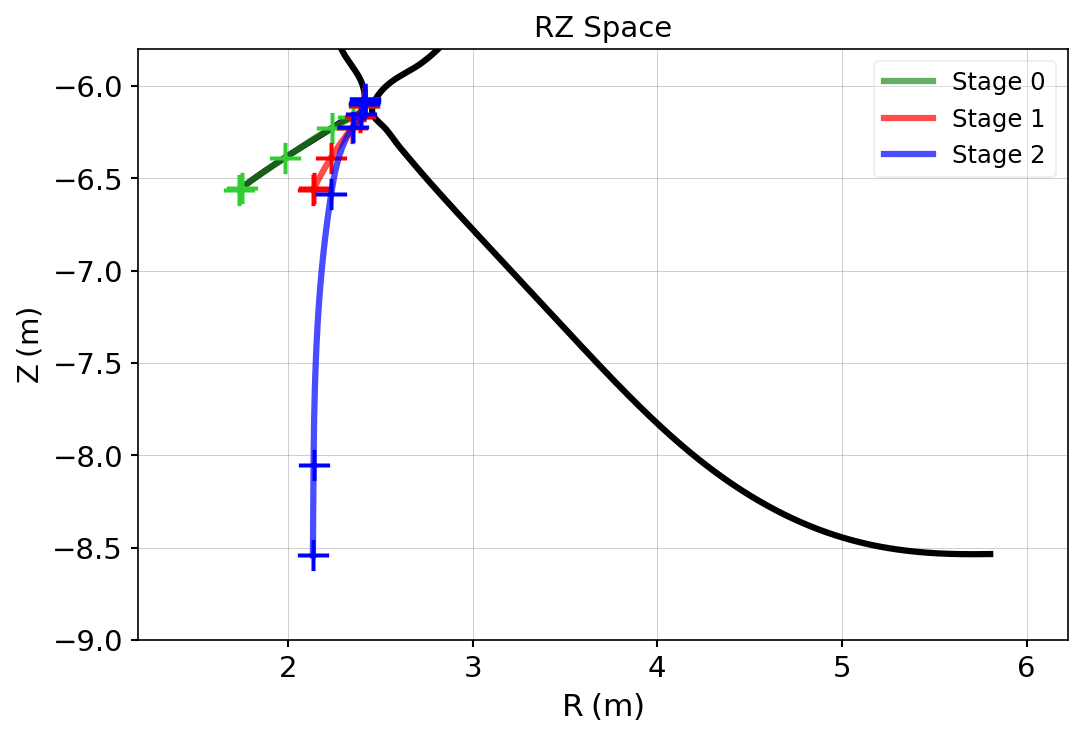

In [11]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])

base_offsets = [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.85},
    {"pos" : 0.7},
    {"pos" : 0.35},
    {"pos" : 0.02},
    {"pos" : 0.0},
    ]

offsets_stage1 = [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0, "offsetx": 0.04},
    {"pos" : 0.7,   "offsety": 0, "offsetx": 0.11},
    {"pos" : 0.35,  "offsety": 0, "offsetx": 0.25},
    {"pos" : 0.02,  "offsety": 0, "offsetx": 0.392},
    {"pos" : 0.0,   "offsety": 0, "offsetx": 0.4},
    ]

offsets_stage2 = [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.85,  "offsety": 0},
    {"pos" : 0.7,   "offsety": 0},
    {"pos" : 0.35,  "offsety": -0.2},
    {"pos" : 0.02,  "offsety": -1.5, "offsetx": -0.002},
    {"pos" : 0.0,   "offsety": -1.98},
    ]


# Make stage 0 by copying the base profile
stage0 = base.copy()
stage0.offset_control_points(base_offsets)
stage0.name = "Stage 0"

# Make stage 1 by offsetting stage 0
stage1 = base.copy()
stage1.offset_control_points(offsets_stage1)
stage1.recalculate_topology()
stage1.name = "Stage 1"

# Make stage 2 by offseting stage 1
stage2 = stage1.copy()
stage2.offset_control_points(offsets_stage2)
stage2.recalculate_topology()
stage2.name = "Stage 2"



plt.close("all")
fig, ax = plt.subplots(dpi = 150)
ax.plot(base.R, base.Z, lw = 3, c = "k")
stage0.plot_control_points(ax = ax)
stage1.plot_control_points(ax = ax, markersettings = {"c" : "r"}, linesettings = {"c" : "r"})
stage2.plot_control_points(ax = ax, markersettings = {"c" : "b"}, linesettings = {"c" : "b"})

d_outer = eqb["SPR45"]["ol"]
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)

ax.legend(fontsize = "small")
ax.set_ylim(-9, -5.8)

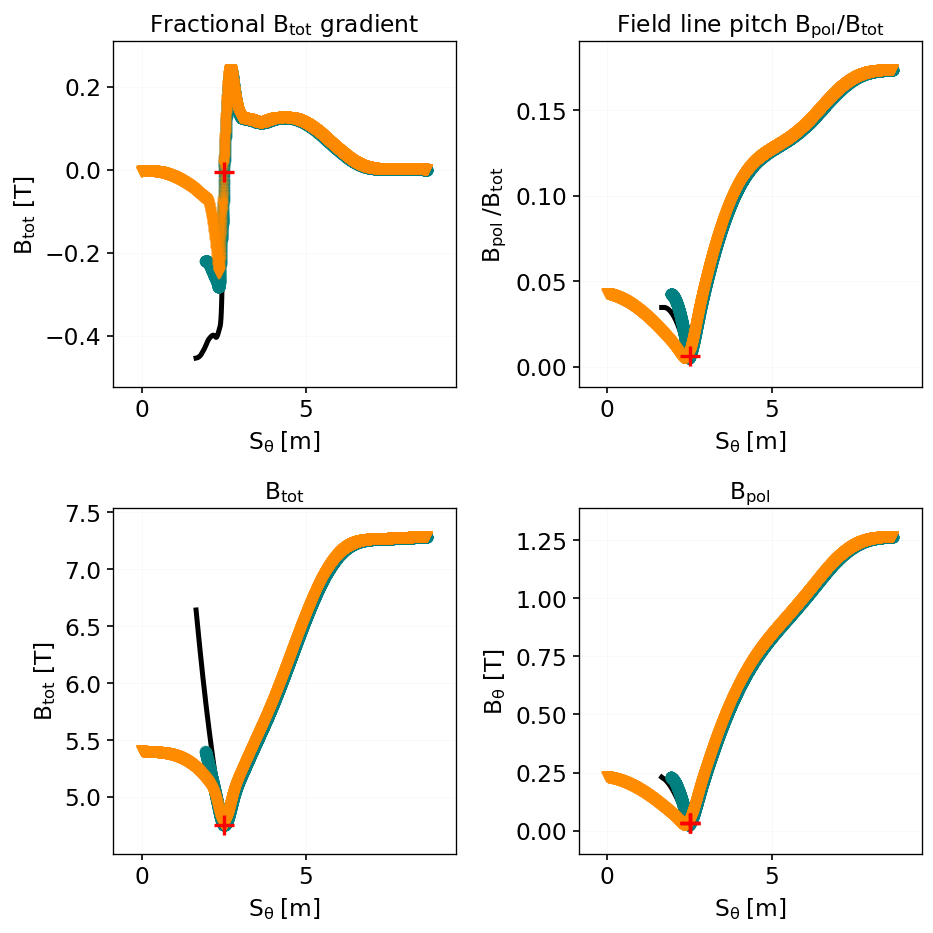

In [12]:
compare_profile_topologies(stage0, [stage1, stage2])

## Morph between any two

In [45]:
%matplotlib widget

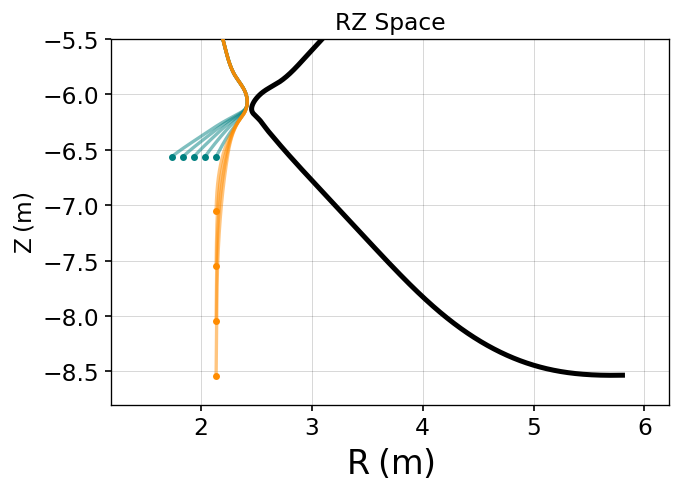

In [13]:
start = stage0.copy()
end = stage1.copy()
new = stage0.copy()
factor = 0

# Make stage 1 by offsetting stage 0
new = base.copy()
new.offset_control_points(offsets_stage1, factor = factor)
new.recalculate_topology()
new.name = "New"

profiles = {}
for i in np.linspace(0,1,5):
    profiles[i] = base.copy()
    profiles[i].offset_control_points(offsets_stage1, factor = i)
    profiles[i].recalculate_topology()
    profiles[i].name = i

for i in np.linspace(1,2,5):
    profiles[i] = stage1.copy()
    profiles[i].offset_control_points(offsets_stage2, factor = i-1)
    profiles[i].recalculate_topology()
    profiles[i].name = i

plt.close("all")
fig, ax = plt.subplots(1, figsize = (6,12))

profs = {}
for i in profiles:
 
    p = profiles[i]
    
    c = "teal" if i <= 1 else "darkorange"
    
    ax.plot(p.R, p.Z, zorder = 100, alpha = 0.5, lw = 2, ls = "-", c = c)
    ax.scatter(p.R[0], p.Z[0], c = c, s = 10)

d_outer = eqb["SPR45"]["ol"]
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)

ax.set_xlabel("$R\ (m)$", fontsize = 20)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

In [14]:
cvar = "density"
design = "SPR45"
side = "il"

store = dict()

    
for i in profiles:
    d = profiles[i].copy()
    constants = constants_default.copy() # Set settings to default
    radios = radios_default.copy() # Set settings to default
    SparRange = np.linspace(0, d["S"][d["Xpoint"]], 100) # Solve at these parallel positions
    
    if "i" in side:
        constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.
    elif "o" in side:
        constants["qpllu0"] = constants_default["qpllu0"] * 2 # Reduce power to 10% for the inner divertor to account for power sharing.

    results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
    
    store[i] = copy.deepcopy(results)

Solving...0...26...52...78...104...130...156...182...208...233...259...284...309...334...358...383...407...430...453...476...499...521...543...564...585...606...626...645...665...683...702...720...737...754...771...787...803...818...833...848...862...876...889...902...914...926...938...949...959...969...978...987...995...1003...1011...1018...1025...1032...1038...1044...1050...1056...1061...1067...1072...1077...1082...1087...1092...1097...1102...1106...1111...1115...1120...1124...1129...1133...1137...1141...1146...1150...1154...1158...1162...1166...1170...1174...1178...1182...1186...1190...1194...1198...1202...1206...1211...1215...1219...1224...Complete in 798.9 seconds
Solving...0...27...54...81...108...135...161...188...215...241...267...293...318...344...368...393...417...441...465...488...510...532...554...576...597...617...637...657...676...694...713...730...748...764...781...797...812...827...842...856...870...883...896...909...921...932...943...954...964...973...982...991...999..

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1109...1113...1117...1122...1126...1130...1135...1139...1143...1147...1151...1155...1159...1163...1167...1171...1175...1179...1183...1187...1190...1194...1198...1202...1207...1211...1215...1219...1224...Complete in 931.2 seconds
Solving...0...28...56...84...112...139...167...194...221...248...275...301...327...353...378...403...428...452...475...498...521...544...565...587...608...628...648...668...686...705...723...740...757...774...790...805...821...835...850...863...877...890...902...914...926...937...948...958...968...977...986...994...1002...1010...1017...1024...1031...1037...1044...1050...1055...1061...1067...1072...1077...1082...1087...1092...1097...1102...1106...1111...1115...1119...1124...1128...1132...1136...1140...1144...1148...1152...1156...1160...1164...1168...1172...1175...1179...1183...1187...1191...1195...1199...1203...1207...1211...1215...1220...1224...Complete in 758.2 seconds
Solving...0...29...58...87...115...144...172...200...228...255...283...309...336...362...388

In [231]:
file_write(store, "2024-01-23 - New inner divertor - 100 points.pkl")

C:\Users\mikek\AppData\Local\Temp\ipykernel_22084\1550407324.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


Text(0.5, 1.0, 'Front position response to upstream density')

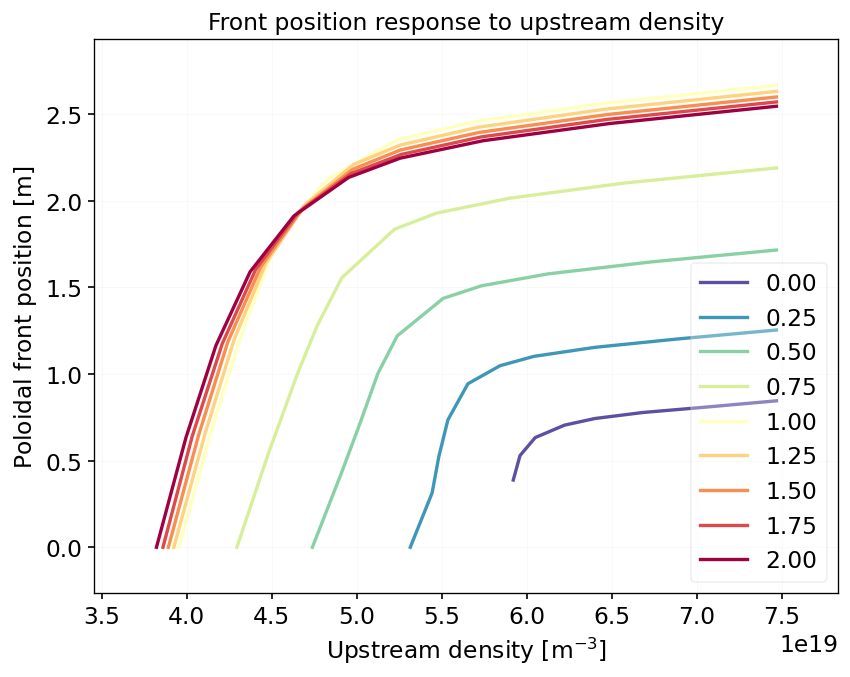

In [23]:
fig, ax = plt.subplots()
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.2f}", color = colors[i], **style)
    
ax.legend()
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

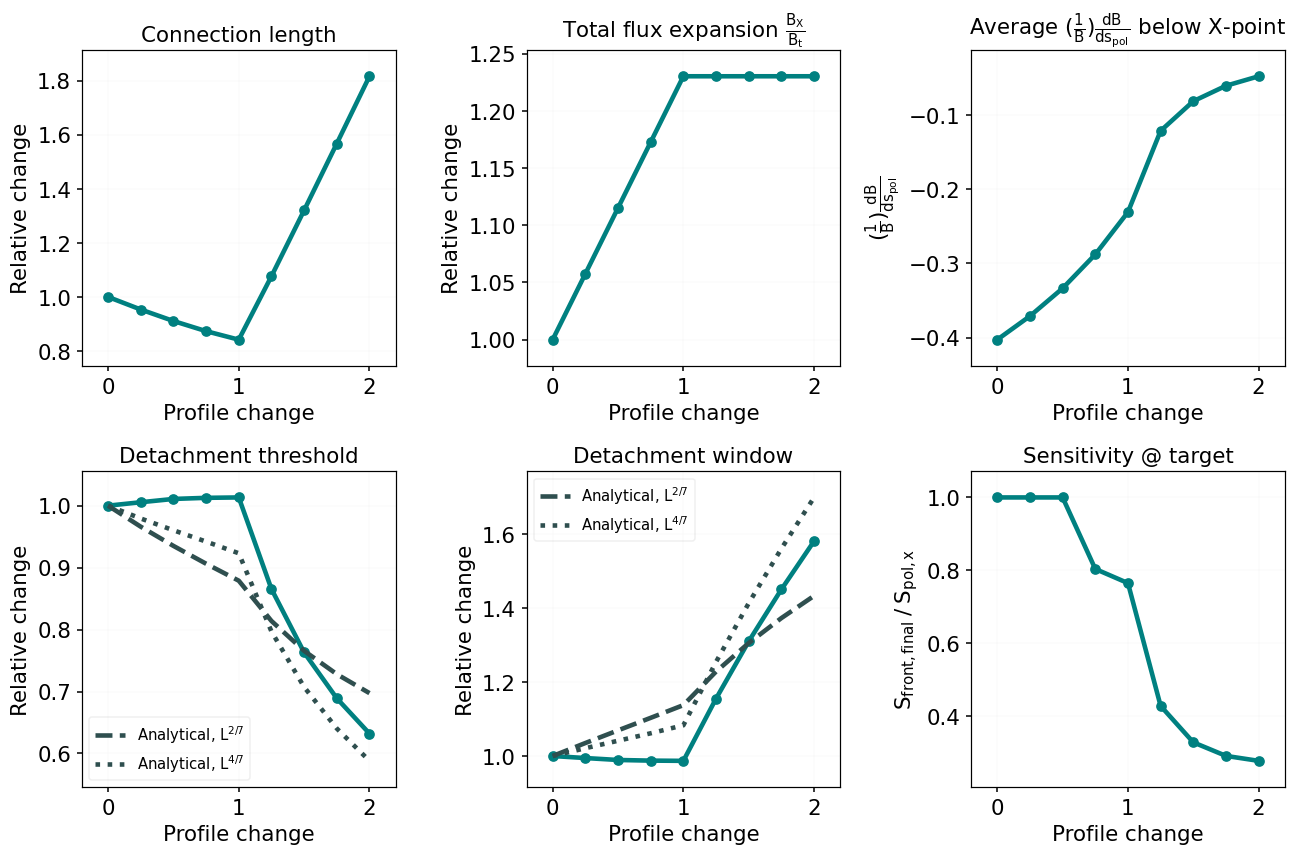

In [44]:
labels = ["Height", "Height and distance"]
colors = ["teal", "darkorange"]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))


    

windows = np.array([store[x]["window_ratio"] for x in profiles])

thresholds = np.array([store[x]["threshold"] for x in profiles])
L = np.array([profiles[x].get_connection_length() for x in profiles])
BxBt = np.array([profiles[x].get_total_flux_expansion() for x in profiles])
frac_gradB = np.array([profiles[x].get_average_frac_gradB() for x in profiles])
avgB_ratio = np.array([profiles[x].get_average_B_ratio() for x in profiles])

target_sens = np.array([get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in profiles])

L_base = L[0]
BxBt_base = BxBt[0]
threshold_base = thresholds[0]
window_base = windows[0]
avgB_ratio_base = avgB_ratio[0]
    
threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)

windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)

index = profiles.keys()

# index = np.linspace(0,1,5)+i
axes[0,0].set_title("Connection length")
axes[0,0].plot(index, L/L_base, marker = "o")

axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
axes[0,1].plot(index, BxBt/BxBt_base, marker = "o")

axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
axes[0,2].plot(index, frac_gradB, marker = "o")

axes[1,0].set_title(r"Detachment threshold")
axes[1,0].plot(index, thresholds/threshold_base, marker = "o")

axes[1,0].plot(index, threshcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,0].plot(index, threshcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,0].legend(fontsize = "x-small")

axes[1,1].set_title(r"Detachment window")
axes[1,1].plot(index, windows/window_base, marker = "o")
axes[1,1].plot(index, windowcalc, color = "darkslategrey", ls = "--", label = None if i == 0 else "Analytical, $L^{2/7}$")
axes[1,1].plot(index, windowcalc2, color = "darkslategrey", ls = ":", label = None if i == 0 else "Analytical, $L^{4/7}$")
axes[1,1].legend(fontsize = "x-small")

axes[1,2].set_title(r"Sensitivity @ target")
axes[1,2].plot(index, target_sens, marker = "o")

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")
    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()

# Analysing front width effect in stage 1

In [82]:
def pad_profile(S, data):
    """
    DLS terminates the domain at the front meaning downstream domain is ignored.
    This adds zeros to a result array data to fill those with zeros according to 
    the distance array S.
    """

    intended_length = len(S)
    actual_length = len(data)

    out = np.insert(data, 0, np.zeros((intended_length - actual_length)))
    
    return out


len(out)

200

In [112]:
%matplotlib inline
plt.close("all")

C:\Users\mikek\AppData\Local\Temp\ipykernel_92296\1195390859.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable)


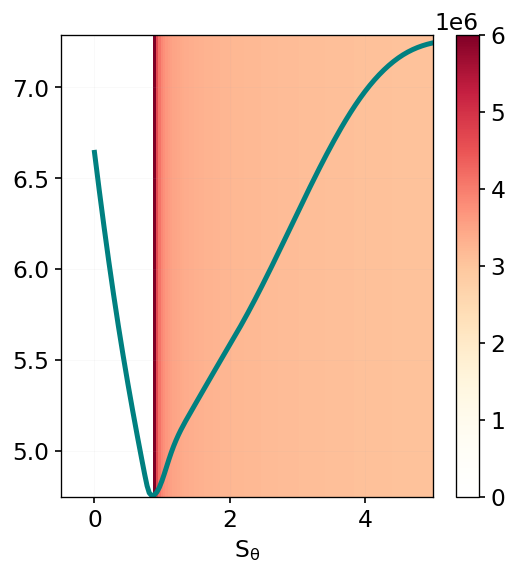

In [221]:
X = p["Spol"]
# X = np.stack([X]*200)

# Y = np.linspace(0,1,200)
Ydata = p["Btot"]
Y = np.linspace(Ydata.min(), Ydata.max(), len(Ydata))
# Y = np.stack([Y]*200)

Z = pad_profile(p["Spol"], s["Rprofiles"][-1])
Z = np.stack([Z]*200)
vmin = Z.min()
vmax = Z.max()
norm = create_norm(False, None, 0, 6e6)


cmap = plt.cm.YlOrRd
my_cmap = cmap(np.arange(cmap.N))
alphas = np.linspace(0,1,cmap.N)
BG = np.asarray([1,1,1])

for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1-alphas[i])

my_cmap = mpl.colors.ListedColormap(my_cmap)

mappable =  mpl.cm.ScalarMappable(norm=norm, cmap= my_cmap)

fig, ax = plt.subplots(figsize = (5,5))
ax.pcolormesh(X, Y, Z, norm = norm, cmap = my_cmap, alpha = 1)
fig.colorbar(mappable)
ax.set_xlim(-0.5,5)
ax.set_xlabel(r"$S_{\theta}$")

ax.plot(X, Ydata)

# Z.shape

# np.reshape(X, (200, len(X))).shape

[0.0, 6628020.823313229, 4620523.618625858, 4112807.0528222276, 3883591.8879863084, 3751260.4368272973, 3663965.402589195, 3601334.27095673, 3553562.5173809174, 3515380.1016150275, 3483839.8936416674, 3457146.2997509968, 3434140.5595226134, 3414038.5339798774, 3396287.565557984, 3380483.7930612927, 3366322.0452471166, 3353548.212429765, 3341934.1396381496, 3331297.7275673375, 3321493.825364133, 3312405.1710109203, 3303935.8825767227, 3296006.6928836294, 3288551.423613745, 3281514.323810251, 3274848.037549567, 3268512.203941777, 3262474.3688336224, 3256708.035374988, 3251189.9775004075, 3245899.741597731, 3240819.2183801318, 3235932.298395032, 3231224.58825623, 3226683.175107857, 3222296.429274289, 3218053.835668856, 3213945.8529404444, 3209963.7958369902, 3206099.660582053, 3202345.771638134, 3198695.034010379, 3195140.991451631, 3191677.7570110615, 3188299.951729444, 3185002.6512240935, 3181781.339021979, 3178631.8655389817, 3175550.412340064, 3172533.4604981733, 3169577.761921886, 31

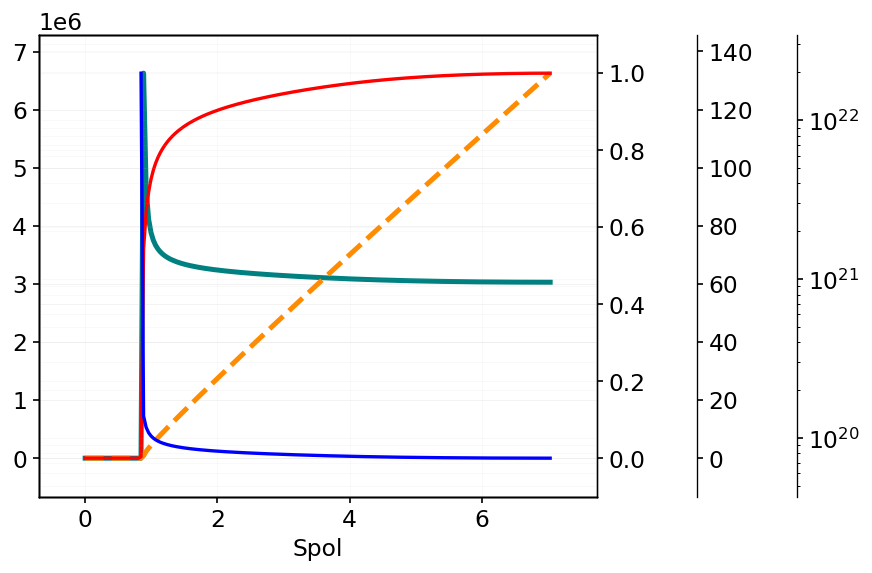

In [232]:
p = profiles[0]
s = store[0]
idx = -1

fig, ax = plt.subplots(figsize = (6,5))


data = s["Rprofiles"][idx]
print(data)

x = p["Spol"]
data = pad_profile(x, data)

T = pad_profile(x, s["Tprofiles"][idx])
P = T[-1] * s["cvar"][idx]
N = P/T

integral = sp.integrate.cumulative_trapezoid(y = data, x = x, initial = 0)
integral /= integral.max()

ax.plot(x, data)

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

ax2.plot(x, integral, color = "darkorange", ls = "--")
ax3.plot(x, pad_profile(x, s["Tprofiles"][idx]), c = "r", lw = 2)
ax4.plot(x, N, c = "b", lw = 2)
ax3.spines["right"].set_position(("outward", 60))
ax4.spines["right"].set_position(("outward", 120))
ax.set_xlabel("Spol")
# ax.set_xlim(0,2)
ax4.set_yscale("log")
# ax4.set_ylim(